In [4]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import os

In [5]:
# Load dataset
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=['user_id', 'movie_id', 'rating', 'timestamp'])

In [6]:
# Display basic statistics and first few rows of the dataset
print(ratings.describe())

            user_id       movie_id         rating     timestamp
count  100000.00000  100000.000000  100000.000000  1.000000e+05
mean      462.48475     425.530130       3.529860  8.835289e+08
std       266.61442     330.798356       1.125674  5.343856e+06
min         1.00000       1.000000       1.000000  8.747247e+08
25%       254.00000     175.000000       3.000000  8.794487e+08
50%       447.00000     322.000000       4.000000  8.828269e+08
75%       682.00000     631.000000       4.000000  8.882600e+08
max       943.00000    1682.000000       5.000000  8.932866e+08


In [7]:
print(ratings.head())

   user_id  movie_id  rating  timestamp
0      196       242       3  881250949
1      186       302       3  891717742
2       22       377       1  878887116
3      244        51       2  880606923
4      166       346       1  886397596


In [20]:
print(ratings.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   user_id    100000 non-null  int64
 1   movie_id   100000 non-null  int64
 2   rating     100000 non-null  int64
 3   timestamp  100000 non-null  int64
dtypes: int64(4)
memory usage: 3.1 MB
None


### Preprocess data

In [8]:
# Encode user IDs and movie IDs to integer indices
label_encoder_user = LabelEncoder()
label_encoder_movie = LabelEncoder()

ratings['user_id'] = label_encoder_user.fit_transform(ratings['user_id'])
ratings['movie_id'] = label_encoder_movie.fit_transform(ratings['movie_id'])

In [9]:
# Split data into features and target variable, then into training and testing sets
X = ratings[['user_id', 'movie_id']]
y = ratings['rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Model parameters

In [10]:
# Determine the number of unique users and movies for embedding layers
num_users = ratings['user_id'].nunique()
num_movies = ratings['movie_id'].nunique()
embedding_size = 50

### NCF Model

In [11]:
# Input layers
user_input = Input(shape=(1,), name='user_input')
movie_input = Input(shape=(1,), name='movie_input')

# Embedding layers
user_embedding = Embedding(num_users, embedding_size, name='user_embedding')(user_input)
movie_embedding = Embedding(num_movies, embedding_size, name='movie_embedding')(movie_input)

# Flatten the embedding vectors
user_vec = Flatten(name='user_flatten')(user_embedding)
movie_vec = Flatten(name='movie_flatten')(movie_embedding)

# Concatenate flattened vectors and add dropout layer
concat = Concatenate()([user_vec, movie_vec])
dense1 = Dense(128, activation='relu')(concat)
dropout = Dropout(0.5)(dense1)
dense2 = Dense(64, activation='relu')(dropout)
output = Dense(1)(dense2)


In [12]:
# Compile and train the model
model = Model([user_input, movie_input], output)
model.compile(optimizer=Adam(0.001), loss='mean_squared_error')

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit([X_train.user_id, X_train.movie_id], y_train, batch_size=64, epochs=20,
                    validation_data=([X_test.user_id, X_test.movie_id], y_test), callbacks=[early_stopping])


Epoch 1/20
1250/1250 [==============================] - 5s 3ms/step - loss: 1.4038 - val_loss: 0.9128
Epoch 2/20
1250/1250 [==============================] - 4s 3ms/step - loss: 0.9457 - val_loss: 0.8927
Epoch 3/20
1250/1250 [==============================] - 4s 4ms/step - loss: 0.8966 - val_loss: 0.8823
Epoch 4/20
1250/1250 [==============================] - 4s 3ms/step - loss: 0.8690 - val_loss: 0.8781
Epoch 5/20
1250/1250 [==============================] - 4s 3ms/step - loss: 0.8475 - val_loss: 0.8849
Epoch 6/20
1250/1250 [==============================] - 4s 3ms/step - loss: 0.8316 - val_loss: 0.8903
Epoch 7/20
1250/1250 [==============================] - 4s 3ms/step - loss: 0.8107 - val_loss: 0.8686
Epoch 8/20
1250/1250 [==============================] - 4s 3ms/step - loss: 0.7909 - val_loss: 0.8616
Epoch 9/20
1250/1250 [==============================] - 4s 4ms/step - loss: 0.7714 - val_loss: 0.8696
Epoch 10/20
1250/1250 [==============================] - 4s 3ms/step - loss: 0.754

### Evaluate model

In [13]:
y_pred = model.predict([X_test.user_id, X_test.movie_id]).flatten()
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')

625/625 [==============================] - 1s 1ms/step
RMSE: 0.9282
MAE: 0.7303


### Plot training & validation loss values

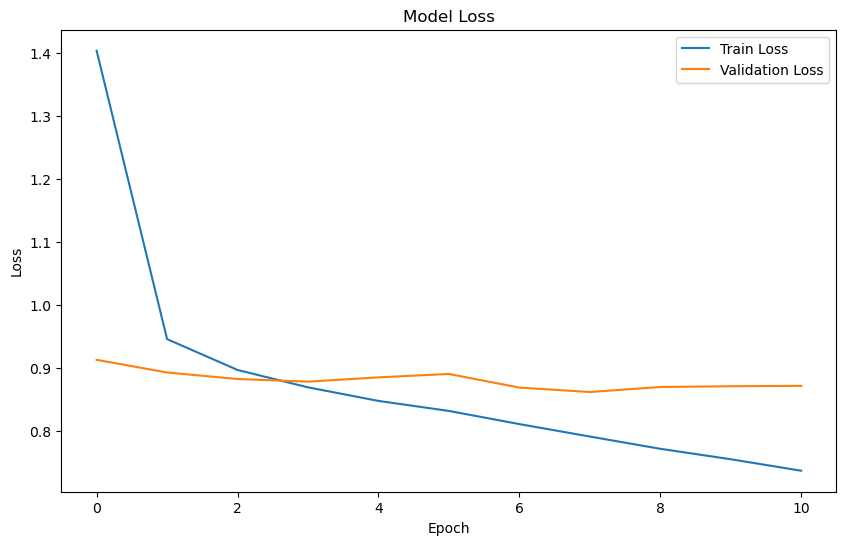

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

### Predict on the test set

In [15]:
y_pred = model.predict([X_test.user_id, X_test.movie_id])

625/625 [==============================] - 1s 2ms/step


### Convert predictions and true values to binary

In [16]:
# Convert predictions and true values to binary (like/dislike) based on a threshold, e.g., 3.5
threshold = 3.5
y_pred_bin = (y_pred > threshold).astype(int)
y_test_bin = (y_test > threshold).astype(int)

### Generate and plot confusion matrix

In [17]:
cm = confusion_matrix(y_test_bin, y_pred_bin)

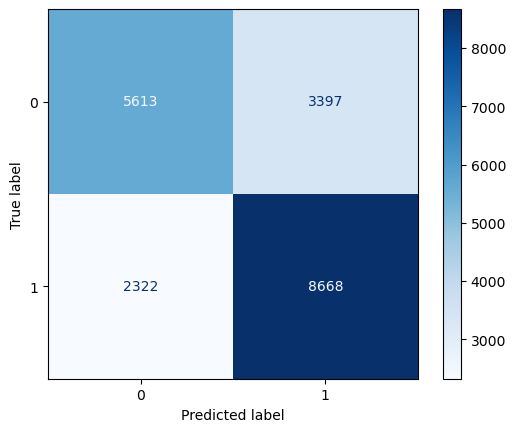

In [18]:
threshold = 3.5
y_pred_bin = (y_pred > threshold).astype(int)
y_test_bin = (y_test > threshold).astype(int)

cm = confusion_matrix(y_test_bin, y_pred_bin)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [19]:
# Save Model
model.save('ncf_model.h5')

C:\Users\junai\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
